In [1]:
import pandas as pd
import re
import nltk
import gensim

train_df = pd.read_csv("../../kaggle_data/train_data.txt",
                       engine="python",
                       sep=" ::: ",
                       names=['id', "movie", "genre", "summary"])

test_df = pd.read_csv("../../kaggle_data/test_data_solution.txt",
                      engine="python",
                      sep=" ::: ",
                      names=['id', "movie", "genre", "summary"])


In [2]:
# Save the DataFrame to a CSV file
train_df.to_csv('train_data_output.csv', index=False)
test_df.to_csv('test_data_output.csv', index=False)

# Load the two DataFrames from CSV files
df1 = pd.read_csv('test_data_output.csv')
df2 = pd.read_csv('train_data_output.csv')

# Concatenate the two DataFrames along the rows
merged_data = pd.concat([df1, df2], axis=0, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
merged_data.to_csv('merged_data.csv', index=False)

In [3]:
df_merged = pd.read_csv('merged_data.csv')

In [4]:
# final data for processing Remove the columns
df = df_merged.drop(columns=['id', 'movie'], axis=1)
df = df.sample(frac=1)
df

,genre,summary
25943,drama,The concubine of the Minister of Law is driven...
38863,horror,"In Hong Kong, the successful designer Ming liv..."
62027,horror,Jamie Anderson has been dealing with terrible ...
103093,documentary,An educational video designed for health teach...
77875,drama,The manger of a suburban swim club gets called...
...,...,...
76369,documentary,"Perhaps unassumed by most, the ancient Egyptia..."
103985,drama,"When the war in Bosnia started in 1984, Omar w..."
18342,drama,"The words ""Black Power"" bring back memories of..."
96790,drama,Laura Elliott's quiet life in the wilderness o...


In [5]:
df

,genre,summary
25943,drama,The concubine of the Minister of Law is driven...
38863,horror,"In Hong Kong, the successful designer Ming liv..."
62027,horror,Jamie Anderson has been dealing with terrible ...
103093,documentary,An educational video designed for health teach...
77875,drama,The manger of a suburban swim club gets called...
...,...,...
76369,documentary,"Perhaps unassumed by most, the ancient Egyptia..."
103985,drama,"When the war in Bosnia started in 1984, Omar w..."
18342,drama,"The words ""Black Power"" bring back memories of..."
96790,drama,Laura Elliott's quiet life in the wilderness o...


In [6]:
# Data Engineering
# Case conversion, Removing special characters, 
# Removing accents, Normalize spaces

from nltk.stem import WordNetLemmatizer

# lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove punctuation
df['summary'] = df['summary'].map(lambda x: re.sub('[:,\.!?-]', '', x))

# Convert the titles to lowercase
df['summary'] = df['summary'].map(lambda x: x.lower())

# # Perform lemmatization
df['summary'] = df['summary'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

 # remove accents
def remove_accents():
    df.summary = [unidecode.unidecode(text) for text in df.summary.values]
    
# #normalized space  
def normalize_spaces():
    df.summary = [re.sub(r"\s+"," ",text) for text in df.summary.values]



In [7]:
df

,genre,summary
25943,drama,the concubine of the minister of law is driven...
38863,horror,in hong kong the successful designer ming life...
62027,horror,jamie anderson ha been dealing with terrible n...
103093,documentary,an educational video designed for health teach...
77875,drama,the manger of a suburban swim club get called ...
...,...,...
76369,documentary,perhaps unassumed by most the ancient egyptian...
103985,drama,when the war in bosnia started in 1984 omar wa...
18342,drama,"the word ""black power"" bring back memory of na..."
96790,drama,laura elliott's quiet life in the wilderness o...


In [8]:
# remove stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.summary.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
df['summary'] = remove_stopwords(data_words)

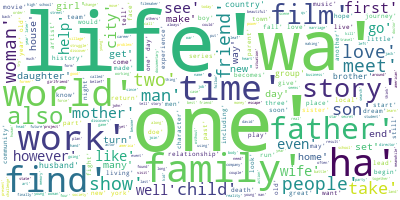

In [9]:
# Exploratory Analysis

# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(df['summary'].apply(str))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=6000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


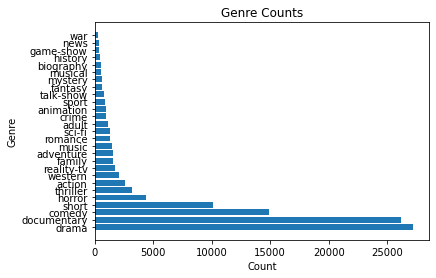

In [10]:
import matplotlib.pyplot as plt

counts = df['genre'].value_counts()

plt.barh(counts.index, counts.values)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Genre Counts')
plt.show()

In [11]:
## tokenizer

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 6), (28, 1), (29, 1)]


In [12]:
#split the data for training and test

from sklearn.model_selection import train_test_split

X = df['summary']
y = df['genre']

# Split the data into training and testing sets, stratifying by y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

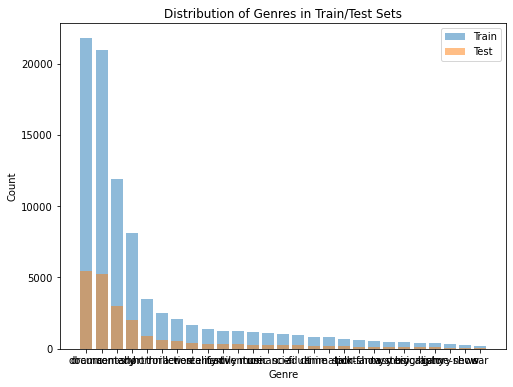

In [13]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(train_counts.index, train_counts.values, alpha=0.5, label='Train')
ax.bar(test_counts.index, test_counts.values, alpha=0.5, label='Test')
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Distribution of Genres in Train/Test Sets')
ax.legend()
plt.show()


In [14]:
X_train.head()

24717    [canadian, aboriginal, music, award, starstudd...
23005    [three, girl, christine, white, irene, anders,...
51881    [two, decade, prison, widmer, former, german, ...
117      [year, old, boy, peering, steering, wheel, dri...
23857    [vast, area, american, prairie, tell, story, y...
Name: summary, dtype: object

In [15]:
y_train.head()

24717          music
23005          drama
51881          drama
117            short
23857    documentary
Name: genre, dtype: object

In [16]:
X_test.head()

30555    [thing, hard, talk, personal, documentary, sec...
48209    [history, america, famous, symbol, conception,...
78199    [sowan, feel, bored, lonely, stayathome, wife,...
32370    [la, pelicula, cuenta, la, historia, de, tres,...
7464     [saroj, dave, leaf, home, mountain, view, cali...
Name: summary, dtype: object

In [17]:
y_test.head()

30555    documentary
48209    documentary
78199          drama
32370         comedy
7464     documentary
Name: genre, dtype: object

In [18]:
X_train.values[1]

['three',
 'girl',
 'christine',
 'white',
 'irene',
 'anders',
 'coleen',
 'miller',
 'living',
 'small',
 'dull',
 'town',
 'dream',
 'glamour',
 'excitement',
 'think',
 'becomes',
 'reality',
 'discover',
 'illegal',
 'money',
 'hidden',
 'one',
 'employer',
 'take',
 'money',
 'go',
 'hollywood',
 'buy',
 'car',
 'clothes',
 'rent',
 'elaborate',
 'house',
 'meet',
 'boy',
 'one',
 'eventually',
 'prof',
 'downfall',
 'man',
 'wa',
 'robbed',
 'find',
 'happy']

In [19]:
df['genre'].head()

25943           drama
38863          horror
62027          horror
103093    documentary
77875           drama
Name: genre, dtype: object

In [20]:
df.head()

,genre,summary
25943,drama,"[concubine, minister, law, driven, house, moth..."
38863,horror,"[hong, kong, successful, designer, ming, life,..."
62027,horror,"[jamie, anderson, ha, dealing, terrible, night..."
103093,documentary,"[educational, video, designed, health, teacher..."
77875,drama,"[manger, suburban, swim, club, get, called, wo..."


In [91]:
df.shape

(108414, 2)

In [48]:
df_test=df

In [49]:
df_test

,genre,summary
25943,drama,"[concubine, minister, law, driven, house, moth..."
38863,horror,"[hong, kong, successful, designer, ming, life,..."
62027,horror,"[jamie, anderson, ha, dealing, terrible, night..."
103093,documentary,"[educational, video, designed, health, teacher..."
77875,drama,"[manger, suburban, swim, club, get, called, wo..."
...,...,...
76369,documentary,"[perhaps, unassumed, ancient, egyptian, unique..."
103985,drama,"[war, bosnia, started, omar, wa, year, old, ch..."
18342,drama,"[word, black, power, bring, back, memory, name..."
96790,drama,"[laura, elliott, quiet, life, wilderness, deso..."


In [50]:
type(df_test)

pandas.core.frame.DataFrame

In [51]:
import pandas as pd

In [52]:
df_test['summary']

25943     [concubine, minister, law, driven, house, moth...
38863     [hong, kong, successful, designer, ming, life,...
62027     [jamie, anderson, ha, dealing, terrible, night...
103093    [educational, video, designed, health, teacher...
77875     [manger, suburban, swim, club, get, called, wo...
                                ...                        
76369     [perhaps, unassumed, ancient, egyptian, unique...
103985    [war, bosnia, started, omar, wa, year, old, ch...
18342     [word, black, power, bring, back, memory, name...
96790     [laura, elliott, quiet, life, wilderness, deso...
106853    [luke, london, artist, thinking, giving, hit, ...
Name: summary, Length: 108414, dtype: object

In [53]:
df_test['summary_str'] = df_test['summary'].apply(' '.join)

In [54]:
df_test.drop(columns=['summary'])

,genre,summary_str
25943,drama,concubine minister law driven house motherinla...
38863,horror,hong kong successful designer ming life belove...
62027,horror,jamie anderson ha dealing terrible nightmare g...
103093,documentary,educational video designed health teacher movi...
77875,drama,manger suburban swim club get called work day ...
...,...,...
76369,documentary,perhaps unassumed ancient egyptian unique atti...
103985,drama,war bosnia started omar wa year old christian ...
18342,drama,word black power bring back memory name like s...
96790,drama,laura elliott quiet life wilderness desolation...


In [55]:
df_group_test=df_test.groupby(['genre']).agg({'summary_str':lambda x: ' '.join(x)})

In [56]:
df_group_test

,summary_str
genre,
action,one man travel across country smuggling illega...
adult,lovely bride equally beautiful bridesmaid shoc...
adventure,story man possessed power life death men comma...
animation,popples animated highenergy children comedy se...
biography,biopic famous spanish folk singer lola flores ...
comedy,two millennial stoner navigate bizarre world c...
crime,thermal town la bourboule man found dead kille...
documentary,educational video designed health teacher movi...
drama,concubine minister law driven house motherinla...


In [57]:
df_group_test.to_csv('grouped_test.csv', index=False)

In [58]:
df_test.to_csv('bf_grouped_test.csv', index=False)

In [59]:
df_group_test.head

<bound method NDFrame.head of                                                    summary_str
genre                                                         
action       one man travel across country smuggling illega...
adult        lovely bride equally beautiful bridesmaid shoc...
adventure    story man possessed power life death men comma...
animation    popples animated highenergy children comedy se...
biography    biopic famous spanish folk singer lola flores ...
comedy       two millennial stoner navigate bizarre world c...
crime        thermal town la bourboule man found dead kille...
documentary  educational video designed health teacher movi...
drama        concubine minister law driven house motherinla...
family       short video built around several short loop ho...
fantasy      drama adapted popular girl comic tell story or...
game-show    summer replacement show rewarded people perfor...
history      according chinese calendar assigned one twelve...
horror       hong kong su

In [60]:
df_group_test.shape

(27, 1)

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# Remove common stopwords
stopwords = set(STOPWORDS)
stopwords.update(['ha', 'wa','film','one','life'])

In [71]:
def mostfreqword(text):
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    my_dict=wordcloud.process_text(text)
    sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: item[1], reverse=True)[:3]}
    return sorted_dict

for index, row in df_group_test.iterrows():
    words=df_group_test.loc[index,'summary_str']
    print(index,"    ",mostfreqword(words))

action      {'find': 669, 'world': 490, 'take': 460}
adult      {'sex': 363, 'woman': 324, 'girl': 319}
adventure      {'find': 360, 'world': 322, 'take': 248}
animation      {'world': 299, 'friend': 238, 'story': 213}
biography      {'story': 166, 'world': 116, 'first': 105}
comedy      {'find': 2378, 'new': 2133, 'friend': 2035}
crime      {'find': 258, 'crime': 249, 'murder': 236}
documentary      {'world': 4899, 'story': 4390, 'people': 4164}
drama      {'family': 5881, 'father': 5540, 'love': 4384}
family      {'family': 530, 'child': 396, 'new': 347}
fantasy      {'world': 282, 'find': 185, 'story': 150}
game-show      {'contestant': 565, 'game': 277, 'team': 274}
history      {'story': 173, 'history': 148, 'new': 106}
horror      {'find': 1075, 'house': 932, 'friend': 764}
music      {'music': 654, 'show': 499, 'band': 495}
musical      {'musical': 172, 'music': 163, 'show': 146}
mystery      {'find': 204, 'murder': 191, 'man': 152}
news      {'new': 261, 'show': 130, 'world': 7